In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime
import statsmodels.tsa.api as smt

# Domain Knowledge

We are asked to make sales predicitions for a software firm in Russia. This is a problem invloved time-series datasets, some models that could work fine for this type of problems are Linear Regresion, Random Forest Regression, XGBoost, LSTM and ARIMA.

The data provided includes:

## File descriptions

- **sales_train.csv**: Train set. Daily historical data from January 2013 to October 2015
- **test.csv**: Test set. You need forecast the sales for these shops and products for November 2015
- **sample_submission.csv**: A sample submission in the correct format
- **items.csv**: Supplemental information about the items/products
- **items_categories.csv**: supplemental information about the items categories
- **shops.csv**: supplemental information about the shops

## Data fields

- **ID**:An id that represents a (Shop, Item) tuple within the test set
- **shop_id**: Unique identifier of a shop
- **item_id**: Unique identifier of a product
- **item_category_id**: Unique identifier of a item category
- **item_cnt_day**: Number of products sold. Your are predicting a monthly amount of this measure
- **item_price**: Current price of a item
- **date**: date in format dd/mm/yyyy
- **date_block_num**: A consecutive month number, used for convinience. January 2013 is 0, February 2013 is 1 ... October 2015 is 33
- **item_name**: Name of item
- **shop_name**: Name of shop
- **item_category_name**: Name of category name

In [2]:
# Import data from csv files
sales_data = pd.read_csv('sales_train.csv')
shops_data = pd.read_csv('shops.csv')
categories_data = pd.read_csv('item_categories.csv')
items_data = pd.read_csv('items.csv')

In [3]:
sales_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [10]:
# Sum sales per day.
df = sales_data.copy()
total_per_day = df.groupby('date').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_per_day.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,28.12.2013,103774,315275,93436151,9.491239e+06,13343.0
1,30.12.2014,214452,309775,94418782,1.220957e+07,13236.0
2,29.12.2013,102685,315291,92980641,9.184175e+06,12863.0
3,30.12.2013,100518,302621,89671936,9.448912e+06,12823.0
4,31.12.2014,191981,275199,83384841,1.127468e+07,11394.0


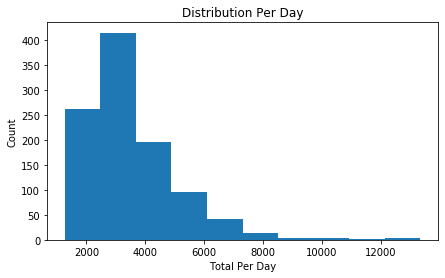

In [7]:
fig, ax = plt.subplots(figsize=(7,4))
plt.hist(total_per_day.item_cnt_day)
ax.set (xlabel = "Total Per Day",
        ylabel = "Count",
        title = "Distribution Per Day")
plt.show()

Most of dayly sales are around 2000 and 4000 items

In [9]:
# Sum sales per month
total_per_month = df.groupby('date_block_num').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_per_month.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,11,4747485,1424369716,1.431799e+08,183342.0
1,23,4339498,1330492992,1.794057e+08,168755.0
2,2,4016457,1220911622,8.429831e+07,147142.0
3,8,3208314,957871641,7.270157e+07,133332.0
4,0,3417068,1183971787,8.221187e+07,131479.0


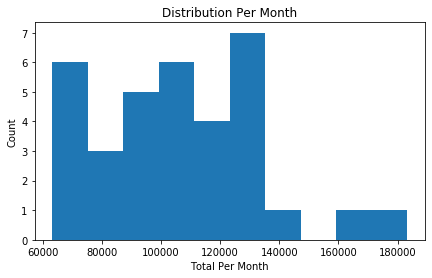

In [20]:
fig, ax = plt.subplots(figsize=(7,4))
plt.hist(total_per_month.item_cnt_day)
ax.set (xlabel = "Total Per Month",
        ylabel = "Count",
        title = "Distribution Per Month")
plt.show()

Most of monthly sales are around 100000 and 140000 items

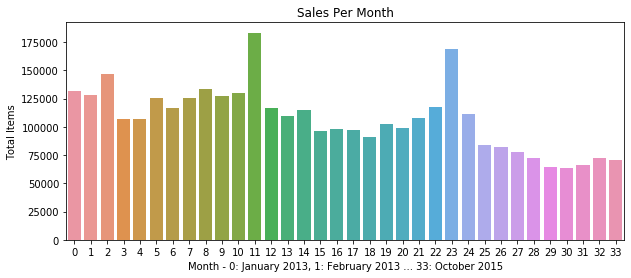

Max:183342.0
Min:63187.0
Mean:107300.17647058824


In [21]:
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(total_per_month.date_block_num, total_per_month.item_cnt_day)
ax.set (xlabel = "Month - 0: January 2013, 1: February 2013 ... 33: October 2015",
        ylabel = "Total Items",
        title = "Sales Per Month")
plt.show()
print("Max:{}".format(total_per_month.item_cnt_day.max()))
print("Min:{}".format(total_per_month.item_cnt_day.min()))
print("Mean:{}".format(total_per_month.item_cnt_day.mean()))

It can be seen that December are the months with higher sales (month 11 and 13). Also is observed that there is a trend of progressive decrease in sales year after year.

Test set is made up of (shop, item) pairs so we should explorer how is the behaviour of sales respect to the shops.

In [22]:
# Sum sales per shop
total_per_shop = df.groupby('shop_id').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_per_shop.head()

,shop_id,date_block_num,item_id,item_price,item_cnt_day
0,31,3519304,2613938432,1.707634e+08,310777.0
1,25,2803911,2017578669,1.555576e+08,241920.0
2,54,1700597,1575568395,1.096694e+08,185790.0
3,28,2106668,1503076500,1.252947e+08,184557.0
4,42,1762898,1149534465,1.015515e+08,144934.0


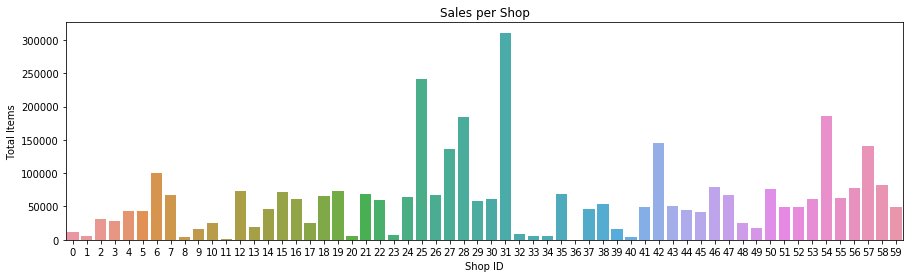

In [23]:
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(total_per_shop.shop_id, total_per_shop.item_cnt_day)
ax.set (xlabel = "Shop ID",
        ylabel = "Total Items",
        title = "Sales per Shop")
plt.show()

Let's see how is the sales' behaviour over the 34 months for shops with less sales (i.e: 8, 40 ...)

In [24]:
df1 = df[df['shop_id'] == 8]
total_shop_low1 = df1.groupby('date_block_num').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_shop_low1

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,11112,13864194,902495.500,1463.0
1,1,8736,11074599,721811.395,1156.0
2,2,7440,9308031,601366.810,977.0
3,3,8,4809,599.000,-1.0


There is somenthing that seems interesting. This shop was open 4 months only. This is a situation that can be found in others shops.

In [25]:
df2 = df[df['shop_id'] == 40]
total_shop_low2 = df2.groupby('date_block_num').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_shop_low2

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,23,33000,11081749,908888.28,1024.0
1,22,17640,5620553,390599.00,515.0
2,14,16280,5591617,345051.00,496.0
3,24,16200,5512981,425048.95,443.0
4,21,14320,4534245,338542.45,422.0
5,20,13520,4382441,339919.64,374.0
6,18,13120,4533783,279750.00,346.0
7,15,11120,4065670,234986.00,338.0
8,19,12400,3867293,281254.00,336.0
9,17,11720,3875424,287497.00,332.0


Shops with top sales (i.e:31, 25), were open for all the 34 months.

In [26]:
df3 = df[df['shop_id'] == 31]
total_shop_high1 = df3.groupby('date_block_num').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_shop_high1

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,11,356283,124459440,8.928759e+06,16318.0
1,23,325314,118242835,1.060955e+07,14610.0
2,2,291927,102970675,5.611423e+06,12670.0
3,10,248775,87851814,5.310881e+06,11710.0
4,8,224843,77337125,4.696030e+06,11204.0
5,1,270785,94875426,5.327247e+06,11160.0
6,9,232841,81990016,4.883418e+06,10754.0
7,0,261609,93377912,5.359620e+06,10173.0
8,5,235104,84975556,4.223224e+06,10072.0
9,12,242916,84226307,5.414882e+06,10017.0


In [27]:
df4 = df[df['shop_id'] == 25]
total_shop_high2 = df4.groupby('date_block_num').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_shop_high2

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,23,217100,94799435,1.053422e+07,12257.0
1,11,217425,91827778,7.707207e+06,12102.0
2,2,190475,81968309,4.983821e+06,9732.0
3,8,150100,62325328,4.266765e+06,9251.0
4,10,152200,65469016,4.548909e+06,8632.0
5,5,159975,68801155,3.803161e+06,8478.0
6,9,148225,63942538,4.263572e+06,8356.0
7,0,174275,76438897,4.685009e+06,8215.0
8,1,161775,69605482,4.480180e+06,7934.0
9,3,165125,71411463,4.080956e+06,7867.0


We built a function to identify the shops that were open for all the 34 months.

In [71]:
# We are going to add a new feature to the shops_data dataframe. 
# ft1 -> How many months the shop was open

shops_data_ft1 = shops_data.copy()
months_open = [len(df[df['shop_id']==x].groupby(['date_block_num']).sum()) for x in shops_data_ft1.shop_id]
shops_data_ft1['months_open'] = months_open
shops_data_ft1.head()

,shop_name,shop_id,months_open
0,"!Якутск Орджоникидзе, 56 фран",0,2
1,"!Якутск ТЦ ""Центральный"" фран",1,2
2,"Адыгея ТЦ ""Мега""",2,34
3,"Балашиха ТРК ""Октябрь-Киномир""",3,34
4,"Волжский ТЦ ""Волга Молл""",4,34


In [72]:
len(shops_data_ft1[shops_data_ft1['months_open'] == 34])

32

Out of 60 shops, only 32 remained open for all the 34 months. But is also possible, that some new shops were opened in the last months, and remain open in the month 34. We built a function to identify these shops.

In [91]:
# We are going to add a new feature to the shops_data dataframe. 
# ft2 -> The shop is open in month 33

shops_data_ft2 = shops_data_ft1
df_tempo = df[df['date_block_num'] == 33]
last_month_open = np.sort(df_tempo['shop_id'].unique())
last_month_open = [x in last_month_open for x in shops_data_ft2.shop_id]
shops_data_ft2['last_month_open'] = last_month_open
shops_data_ft2.head()

,shop_name,shop_id,months_open,last_month_open
0,"!Якутск Орджоникидзе, 56 фран",0,2,False
1,"!Якутск ТЦ ""Центральный"" фран",1,2,False
2,"Адыгея ТЦ ""Мега""",2,34,True
3,"Балашиха ТРК ""Октябрь-Киномир""",3,34,True
4,"Волжский ТЦ ""Волга Молл""",4,34,True


So far we have created two new fwatures that could add important information to the model (months_open, last_month_open). But first, let's review test set, to see if in this set all the shops are included.

In [94]:
test_data = pd.read_csv('test.csv')
test_shop = test_data.shop_id.unique()
test_shop = np.sort(test_shop)
test_shop

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59])

It is clear that some shops have bee excluded from the test set. Let's try to find if the reason is related to their status (is still open? has been open all the 34 months?)

In [98]:
shops_data_tempo = shops_data_ft2
is_test = [x in test_shop for x in shops_data_tempo.shop_id]
shops_data_tempo['is_test'] = is_test

shops_data_tempo

,shop_name,shop_id,months_open,last_month_open,is_test
0,"!Якутск Орджоникидзе, 56 фран",0,2,False,False
1,"!Якутск ТЦ ""Центральный"" фран",1,2,False,False
2,"Адыгея ТЦ ""Мега""",2,34,True,True
3,"Балашиха ТРК ""Октябрь-Киномир""",3,34,True,True
4,"Волжский ТЦ ""Волга Молл""",4,34,True,True
5,"Вологда ТРЦ ""Мармелад""",5,33,True,True
6,"Воронеж (Плехановская, 13)",6,34,True,True
7,"Воронеж ТРЦ ""Максимир""",7,34,True,True
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,4,False,False
9,Выездная Торговля,9,4,True,False


Acording to this, in the test set only are included the shops that are open in the 34th month. The only exceptions are shops 9 y 20.

In [101]:
df_tempo = df[df['shop_id'] == 9]
total_shop_high1 = df_tempo.groupby('date_block_num').sum().sort_values(by=['date_block_num'], ascending = True).reset_index()
total_shop_high1

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,9,13392,17668038,1.617737e+06,6526.0
1,21,12753,18231529,1.839812e+06,6155.0
2,27,9,5672,3.190000e+03,-1.0
3,33,7605,13386757,1.253564e+06,3186.0


In [102]:
df_tempo = df[df['shop_id'] == 20]
total_shop_high1 = df_tempo.groupby('date_block_num').sum().sort_values(by=['date_block_num'], ascending = True).reset_index()
total_shop_high1

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,21,18900,16550232,1.150218e+06,3261.0
1,33,16940,13563669,1.239048e+06,2611.0


As we can see, those two shops looks like it just has been re-opened in the month 33. Therefore, the information that those two shops deliver seems not to be meaningful. With this information, we could built a **new train set** that includes only shops that are open at month 33 and eliminating shops 9 and 20. In other words, the shops included in the **test set**

In [104]:
df_train = df.copy()
print(df_train.shape)
df_train = df_train.loc[df_train['shop_id'].isin(test_shop)]
print(df_train.shape)

(2935849, 6)
(2413246, 6)


Now let's see how this change the total sales per month and the total sales per shop

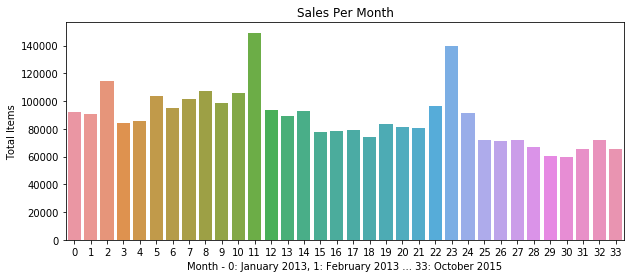

Max:149312.0
Min:59961.0
Mean:87953.23529411765


In [105]:
total_per_month_2 = df_train.groupby('date_block_num').sum().reset_index()
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(total_per_month_2.date_block_num, total_per_month_2.item_cnt_day)
ax.set (xlabel = "Month - 0: January 2013, 1: February 2013 ... 33: October 2015",
        ylabel = "Total Items",
        title = "Sales Per Month")
plt.show()
print("Max:{}".format(total_per_month_2.item_cnt_day.max()))
print("Min:{}".format(total_per_month_2.item_cnt_day.min()))
print("Mean:{}".format(total_per_month_2.item_cnt_day.mean()))

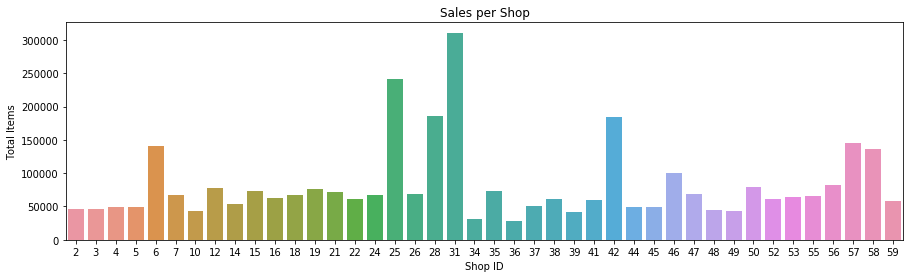

In [107]:
total_per_shop_2 = df_train.groupby('shop_id').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()

fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(total_per_shop_2.shop_id, total_per_shop.item_cnt_day)
ax.set (xlabel = "Shop ID",
        ylabel = "Total Items",
        title = "Sales per Shop")
plt.show()

In [113]:
len(test_data.item_id.unique())

5100

In [ ]:
# TODO 
# previous-value-benchmark

#---------------------


# La categoría a la que pertence un producto puede influir en que tanto se vende
# En el archivo para test se encuentran tanto el shop_id como el item_id. Se debe revisar si se pueden realizar modelos por tienda y luego sumarlos 
# Hay tiendas como la shop_id 8 que solo tiene ventas registradas en los primeros 4 meses cierres (posible cierre)
# Otras como la shop_id reporta ventas entre los meses 14 y 24
# Hacer un ejercicio similar al realizado con las tiendas, con los productos, revisar su variación de precios en el tiempo
# la variación en la demanda, temporadas, etc
